# 3D Reconstruction Project

Follow Theses Steps to Complete a 3D Reconstruction by Point Cloud in Colored format

### Step 1 : Load Photos taken for chessboard by alligned horizontal cameras

In [1]:
# your code here
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import glob

chessboardSize = (9,6)
frameSize = (640,480)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)
objp*=25

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.

#list of directories
imagesLeft = glob.glob('D:/courses/Electro Pi/Computer vision/mid level/Point cloud/calib_images/stereoleft/*.png') 
imagesRight = glob.glob('D:/courses/Electro Pi/Computer vision/mid level/Point cloud/calib_images/stereoright/*.png')

# termination criteria for Corners will be used down in our loop 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# Criteria : cv2.TERM_CRITERIA_EPS for accuracy of change 0.001  "Epsilon"
# Criteria : cv2.TERM_CRITERIA_MAX_ITER 30 "Iterations"
# Your Code will be terminated whenever any one got reached
for imgLeft, imgRight in zip(imagesLeft, imagesRight):

    imgL = cv2.imread(imgLeft)
    imgR = cv2.imread(imgRight)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    retL, cornersL = cv2.findChessboardCorners(grayL, chessboardSize, None)
    retR, cornersR = cv2.findChessboardCorners(grayR, chessboardSize, None)
    # If found, add object points, image points (after refining them)
    if retL and retR == True:

        objpoints.append(objp)
        # Corners refinement  ( image , Corners , Kernel , Zero Zone  when its -1,-1 means no rejection , criteria
        cornersL = cv2.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), criteria)
        
        imgpointsL.append(cornersL)

        cornersR = cv2.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), criteria)
        imgpointsR.append(cornersR)

        # Draw and display the corners
        cv2.drawChessboardCorners(imgL, chessboardSize, cornersL, retL)
        cv2.imshow('img left', imgL)
        cv2.drawChessboardCorners(imgR, chessboardSize, cornersR, retR)
        cv2.imshow('img right', imgR)
        
        cv2.waitKey(1000)


cv2.destroyAllWindows()

       


### Step 2 : Calibrate Stereo Cameras and print New Camera matrix L and R

In [2]:
# your Code here
retL, cameraMatrixL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpointsL, frameSize, None, None)
heightL, widthL, channelsL = imgL.shape
newCameraMatrixL, roi_L = cv2.getOptimalNewCameraMatrix(cameraMatrixL, distL, (widthL, heightL), 1, (widthL, heightL))

retR, cameraMatrixR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpointsR, frameSize, None, None)
heightR, widthR, channelsR = imgR.shape
newCameraMatrixR, roi_R = cv2.getOptimalNewCameraMatrix(cameraMatrixR, distR, (widthR, heightR), 1, (widthR, heightR))

########## Stereo Vision Calibration #############################################

flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
print(flags)
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 

criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retStereo, newCameraMatrixL, distL, newCameraMatrixR, distR, rot, trans, essentialMatrix, fundamentalMatrix = cv2.stereoCalibrate(objpoints, imgpointsL, imgpointsR, newCameraMatrixL,
                                                                                                                                  distL, newCameraMatrixR, distR, grayL.shape[::-1],
                                                                                                                                  criteria_stereo, flags)

print(newCameraMatrixL)


256
[[1.70700513e+03 0.00000000e+00 2.00254486e+02]
 [0.00000000e+00 1.69773987e+03 2.03350267e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Step 3 : Rectify your Stereo Camera ( THIS TIME SAVE Q also)

In [3]:
# Your Code here
rectifyScale= 1
rectL, rectR, projMatrixL, projMatrixR, Q, roi_L, roi_R= cv2.stereoRectify(newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], rot, trans, rectifyScale,(0,0))

stereoMapL = cv2.initUndistortRectifyMap(newCameraMatrixL, distL, rectL, projMatrixL, grayL.shape[::-1], cv2.CV_16SC2)
stereoMapR = cv2.initUndistortRectifyMap(newCameraMatrixR, distR, rectR, projMatrixR, grayR.shape[::-1], cv2.CV_16SC2)

print("Saving parameters!")
cv_file = cv2.FileStorage('stereoMap.xml', cv2.FILE_STORAGE_WRITE)

cv_file.write('stereoMapL_x',stereoMapL[0])
cv_file.write('stereoMapL_y',stereoMapL[1])
cv_file.write('stereoMapR_x',stereoMapR[0])
cv_file.write('stereoMapR_y',stereoMapR[1])
cv_file.write('Q',Q)

cv_file.release()


Saving parameters!


In [4]:
print(Q)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.33243546e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -2.56172506e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.70862457e+03]
 [ 0.00000000e+00  0.00000000e+00  1.08867905e-02 -0.00000000e+00]]


### Step 4 : Build a Function the downsample your image by any given factor
>hint :look for `cv2.pyrdown`.

In [5]:
#your code here
def downsample(img,scale):
    for i in range(scale):
        lower = cv2.pyrDown(img)
    return lower


### Step 5 : Call your matrices (Q matrix included) then remap 2 images and show them.

In [6]:
#your code here
# Camera parameters to undistort and rectify images
cv_file = cv2.FileStorage()
cv_file.open('stereoMap.xml', cv2.FileStorage_READ) # Load XML Stereo map file

# Get our Stereo Matrices
stereoMapL_x = cv_file.getNode('stereoMapL_x').mat()
stereoMapL_y = cv_file.getNode('stereoMapL_y').mat()
stereoMapR_x = cv_file.getNode('stereoMapR_x').mat()
stereoMapR_y = cv_file.getNode('stereoMapR_y').mat()

Q=cv_file.getNode('Q').mat()

frameL= cv2.imread('Lim1.png')
frameR= cv2.imread('Rim1.png')
    # Undistort and rectify images       # Our Other Interpolation techniques are not supported in this function
undistortedL= cv2.remap(frameL, stereoMapL_x, stereoMapL_y, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
undistortedR= cv2.remap(frameR, stereoMapR_x, stereoMapR_y, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)




### Step 6 : Downsample your image by 3 and covert it to gray to be ready for blockmatching

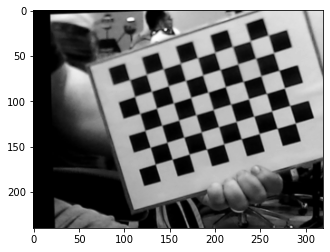

In [7]:
# your code here
downsampleL= downsample(undistortedL,3)
downsampleL= cv2.cvtColor(downsampleL,cv2.COLOR_BGR2GRAY) 
plt.imshow(downsampleL,'gray')

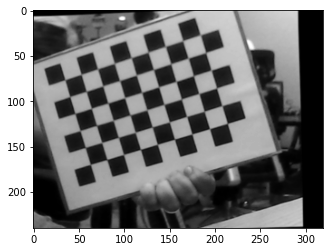

In [8]:
# your code here
downsampleR= downsample(undistortedR,3)
downsampleR= cv2.cvtColor(downsampleR,cv2.COLOR_BGR2GRAY) 
plt.imshow(downsampleR,'gray')

### Step 7 : Perform Block Matching on 2 stereo rectified gray images.  
>hint : look at `cv2.stereoBM()` and know about parameters (https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html)

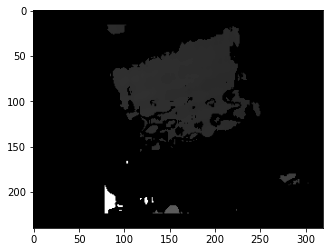

In [14]:
# your code here 
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=33)
disparity = stereo.compute(downsampleL,downsampleR)
plt.imshow(disparity,'gray')
plt.show()

### Step 8: Now lets reproject it into 3D  and save it here i can help you with comments and code
> replace None Values !

doc for `cv2.reprojectImageto3D` (https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02)

In [15]:
# Reproject points into 3D 
points_3D = cv2.reprojectImageTo3D(disparity ,Q , handleMissingValues=False)
# Get color of the reprojected points
colors = cv2.cvtColor(downsampleR, cv2.COLOR_BGR2RGB)

# Get rid of points with value 0 (no depth)
mask_map = disparity > disparity.min()

# Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]


# Function to create point cloud file
def create_point_cloud_file(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')


output_file = 'pointCloud.ply'

# Generate point cloud file
create_point_cloud_file(output_points, output_colors, output_file)

# Visualize it on meshlab !